In [3]:
import os
import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.ops import deform_conv2d
import timm
from tqdm import tqdm

# ==========================================
#               CONFIGURATION
# ==========================================
CONFIG = {
    'model_name': 'eva02_tiny_patch14_224.mim_in22k', # Pretrained ViT
    'img_size': 224,
    'batch_size': 32,
    'epochs': 15,
    'lr': 1e-4,
    'weight_decay': 0.01,
    'patience': 5,
    'num_classes': 4, # Kaggle usually: Glioma, Meningioma, Pituitary, NoTumor
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': 'dataset_final/',  # <--- UPDATE THIS PATH
    'checkpoint_path': 'hybrid_eva02_dcnn_best.pth',
    'seed': 42,
}

# ==========================================
#           1. UTILITIES & DATA
# ==========================================
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_dataloaders(data_dir):
    transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # --- CORRECTED LOADING LOGIC ---
    # We point ImageFolder specifically to the 'train' and 'val' subfolders
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')

    if not os.path.exists(train_dir):
        print(f"ERROR: Training folder not found at {train_dir}")
        exit()

    # Load datasets directly from their respective folders
    # No random_split needed because files are already physically separated
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"Correct Classes Found: {train_dataset.classes}")
    print(f"Train Images: {len(train_dataset)} | Val Images: {len(val_dataset)}")
    
    return train_loader, val_loader

# ==========================================
#        2. ARCHITECTURE COMPONENTS
# ==========================================

class LocalCNNBranch(nn.Module):
    """
    A lightweight CNN to extract local textures/edges.
    Downsamples 224x224 -> 16x16 to match the ViT patch grid.
    """
    def __init__(self, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 28 -> 14 (Matches Eva02 patch grid 224/16 = 14)
            nn.Conv2d(256, out_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.SiLU()
        )

    def forward(self, x):
        return self.net(x)

class CrossAttentionFusion(nn.Module):
    """
    Fuses Local CNN features (Query) with Global ViT features (Key/Value).
    Handles different sequence lengths between CNN and ViT.
    """
    def __init__(self, dim, num_heads=4, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.q_proj = nn.Linear(dim, dim, bias=qkv_bias) # For CNN
        self.k_proj = nn.Linear(dim, dim, bias=qkv_bias) # For ViT
        self.v_proj = nn.Linear(dim, dim, bias=qkv_bias) # For ViT

        self.proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x_local, x_global):
        # x_local: [Batch, Channels, H, W] (CNN Feature Map)
        B, C, H, W = x_local.shape
        # Flatten CNN to [Batch, N_local, C] -> This is our Query length
        x_local_flat = x_local.flatten(2).transpose(1, 2) 
        
        # x_global: [Batch, N_vit, C] (ViT Tokens) -> This is our Key/Value length
        B_v, N_vit, C_v = x_global.shape

        # --- Projections ---
        # 1. Query (CNN): Uses H*W (196)
        q = self.q_proj(x_local_flat).reshape(B, H*W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        
        # 2. Key & Value (ViT): Uses N_vit (256) 
        # (This was the cause of the error; we now use N_vit instead of H*W)
        k = self.k_proj(x_global).reshape(B, N_vit, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v_proj(x_global).reshape(B, N_vit, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        # --- Attention ---
        # Matrix multiplication: (Q @ K.T)
        # Shape: [Batch, Heads, 196, 256] -> Maps 256 ViT tokens to 196 CNN locations
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # --- Weighted Sum ---
        # (Attn @ V) -> Shape: [Batch, Heads, 196, Head_Dim]
        x = (attn @ v).transpose(1, 2).reshape(B, H*W, C)
        
        # Project back
        x = self.proj(x)
        
        # Residual + Norm
        x = self.norm(x + x_local_flat)
        
        # Reshape back to CNN spatial dimensions [Batch, C, 14, 14]
        return x.transpose(1, 2).reshape(B, C, H, W)

class DeformableDCNNHead(nn.Module):
    """
    Applies Deformable Convolution to handle irregular tumor boundaries.
    """
    def __init__(self, dim, num_classes):
        super().__init__()
        
        # Offset predictor: learns WHERE to look
        self.offset_conv = nn.Conv2d(dim, 2 * 3 * 3, kernel_size=3, padding=1)
        
        # The actual weights for the convolution
        self.deform_weight = nn.Parameter(torch.Tensor(dim, dim, 3, 3))
        nn.init.kaiming_uniform_(self.deform_weight, nonlinearity='relu')
        
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.GELU()
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        # x shape: [Batch, Dim, 14, 14]
        
        # 1. Predict Offsets
        offsets = self.offset_conv(x)
        
        # 2. Apply Deformable Conv
        x = deform_conv2d(x, offsets, self.deform_weight, padding=1)
        x = self.act(self.bn(x))
        
        # 3. Classify
        x = self.global_pool(x).flatten(1)
        logits = self.classifier(x)
        return logits

# ==========================================
#           3. THE HYBRID MODEL
# ==========================================
class HybridEva02_DCNN(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        
        # --- Branch A: Eva-02 Transformer ---
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.embed_dim = self.vit.num_features 
        
        # --- Branch B: Local CNN ---
        self.cnn = LocalCNNBranch(out_dim=self.embed_dim)
        
        # --- Fusion: Cross Attention ---
        self.fusion = CrossAttentionFusion(dim=self.embed_dim)
        
        # --- Head: Deformable CNN ---
        self.head = DeformableDCNNHead(dim=self.embed_dim, num_classes=num_classes)

    def forward(self, x):
        # 1. Global Features (ViT)
        # forward_features returns [Batch, 1+256, Dim]. 
        # We slice [:, 1:, :] to remove the class token. 
        # Result: [Batch, 256, Dim]
        x_vit = self.vit.forward_features(x)[:, 1:, :] 
        
        # 2. Local Features (CNN)
        # Result: [Batch, Dim, 14, 14]
        x_cnn = self.cnn(x) 
        
        # 3. Cross Attention Fusion
        # Now handles the 256 vs 196 mismatch automatically
        x_fused = self.fusion(x_local=x_cnn, x_global=x_vit)
        
        # 4. Deformable Classification
        logits = self.head(x_fused)
        
        return logits

# ==========================================
#             4. TRAINING LOOP
# ==========================================
def train_engine():
    seed_everything(CONFIG['seed'])
    
    # Init Data and Model
    print("Initializing Data Loaders...")
    train_loader, val_loader = get_dataloaders(CONFIG['data_dir'])
    
    print(f"Initializing Hybrid Model ({CONFIG['model_name']})...")
    model = HybridEva02_DCNN(CONFIG['model_name'], CONFIG['num_classes']).to(CONFIG['device'])
    
    # Optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    best_acc = 0.0
    
    print("Starting Training...")
    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping (Stability for Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
            
        train_acc = correct / total
        
        # --- VALIDATION ---
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1} Result: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(val_acc)
        
        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CONFIG['checkpoint_path'])
            print(f"--> New Best Model Saved! ({best_acc:.4f})")
            
    print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

if __name__ == "__main__":
    train_engine()

Initializing Data Loaders...
Correct Classes Found: ['heavy', 'light', 'medium']
Train Images: 2694 | Val Images: 164
Initializing Hybrid Model (eva02_tiny_patch14_224.mim_in22k)...
Starting Training...


Epoch 1/15 [Train]: 100%|██████████| 85/85 [00:22<00:00,  3.80it/s, loss=0.0293, acc=0.639]


Epoch 1 Result: Train Acc: 0.6388 | Val Acc: 0.7744 | Val Loss: 0.8320
--> New Best Model Saved! (0.7744)


Epoch 2/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.10it/s, loss=0.0212, acc=0.746]


Epoch 2 Result: Train Acc: 0.7457 | Val Acc: 0.8232 | Val Loss: 0.7358
--> New Best Model Saved! (0.8232)


Epoch 3/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s, loss=0.018, acc=0.789] 


Epoch 3 Result: Train Acc: 0.7892 | Val Acc: 0.7500 | Val Loss: 0.9541


Epoch 4/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.06it/s, loss=0.0133, acc=0.854]


Epoch 4 Result: Train Acc: 0.8537 | Val Acc: 0.8232 | Val Loss: 0.8276


Epoch 5/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s, loss=0.00982, acc=0.9]  


Epoch 5 Result: Train Acc: 0.9001 | Val Acc: 0.9085 | Val Loss: 0.4978
--> New Best Model Saved! (0.9085)


Epoch 6/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.13it/s, loss=0.00769, acc=0.92] 


Epoch 6 Result: Train Acc: 0.9198 | Val Acc: 0.8476 | Val Loss: 0.4176


Epoch 7/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s, loss=0.00661, acc=0.934]


Epoch 7 Result: Train Acc: 0.9343 | Val Acc: 0.8841 | Val Loss: 0.3426


Epoch 8/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s, loss=0.00599, acc=0.951]


Epoch 8 Result: Train Acc: 0.9510 | Val Acc: 0.8232 | Val Loss: 0.6593


Epoch 9/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.09it/s, loss=0.00339, acc=0.97] 


Epoch 9 Result: Train Acc: 0.9703 | Val Acc: 0.9024 | Val Loss: 0.5691


Epoch 10/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s, loss=0.00176, acc=0.987]


Epoch 10 Result: Train Acc: 0.9870 | Val Acc: 0.9085 | Val Loss: 0.6168


Epoch 11/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.12it/s, loss=0.00185, acc=0.986]


Epoch 11 Result: Train Acc: 0.9859 | Val Acc: 0.9268 | Val Loss: 0.5717
--> New Best Model Saved! (0.9268)


Epoch 12/15 [Train]: 100%|██████████| 85/85 [00:20<00:00,  4.11it/s, loss=0.00152, acc=0.99]  


Epoch 12 Result: Train Acc: 0.9903 | Val Acc: 0.8963 | Val Loss: 0.7272


Epoch 13/15 [Train]: 100%|██████████| 85/85 [00:21<00:00,  4.04it/s, loss=0.000468, acc=0.998]


Epoch 13 Result: Train Acc: 0.9978 | Val Acc: 0.9207 | Val Loss: 0.6602


Epoch 14/15 [Train]: 100%|██████████| 85/85 [00:21<00:00,  4.00it/s, loss=0.00109, acc=0.993] 


Epoch 14 Result: Train Acc: 0.9933 | Val Acc: 0.8963 | Val Loss: 0.8077


Epoch 15/15 [Train]: 100%|██████████| 85/85 [00:21<00:00,  4.01it/s, loss=0.000377, acc=0.997]


Epoch 15 Result: Train Acc: 0.9970 | Val Acc: 0.9024 | Val Loss: 0.8524

Training Complete. Best Validation Accuracy: 0.9268


Test Classes: ['heavy', 'light', 'medium']
Test Images: 93

Running Test Evaluation...

 Test Accuracy: 0.9247
 Test Loss:     0.4360

Classification Report:
              precision    recall  f1-score   support

       heavy       0.93      0.96      0.95        27
       light       0.95      0.95      0.95        39
      medium       0.88      0.85      0.87        27

    accuracy                           0.92        93
   macro avg       0.92      0.92      0.92        93
weighted avg       0.92      0.92      0.92        93

Confusion Matrix:
[[26  0  1]
 [ 0 37  2]
 [ 2  2 23]]


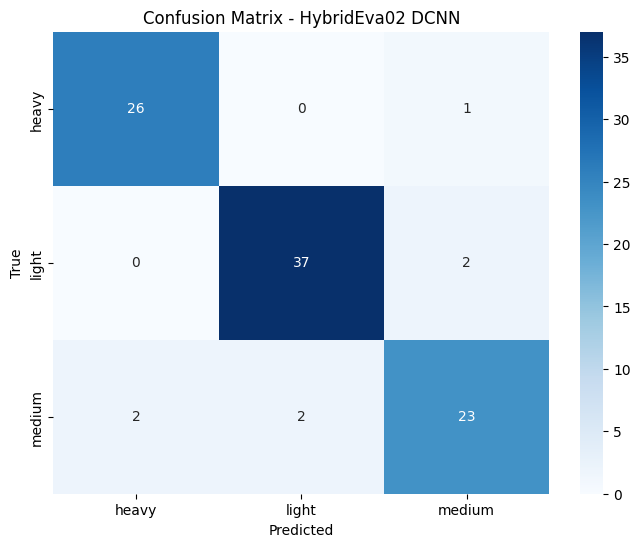

In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load Test Data
# -----------------------------
def get_test_loader(test_dir, img_size=224, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Test Classes: {test_dataset.classes}")
    print(f"Test Images: {len(test_dataset)}")

    return test_loader, test_dataset.classes


# ------------------------------------------
# Load Model & Evaluate on Test Set
# ------------------------------------------
def test_model():
    device = CONFIG["device"]

    # Load Test Loader
    test_dir = os.path.join(CONFIG["data_dir"], "test")
    test_loader, class_names = get_test_loader(test_dir, CONFIG["img_size"], CONFIG["batch_size"])

    # Load Model
    model = HybridEva02_DCNN(CONFIG['model_name'], CONFIG['num_classes'])
    model.load_state_dict(torch.load(CONFIG["checkpoint_path"], map_location=device))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    total = 0
    correct = 0
    total_loss = 0.0

    all_labels = []
    all_preds = []

    print("\nRunning Test Evaluation...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = correct / total
    avg_loss = total_loss / len(test_loader)

    print(f"\n===============================")
    print(f" Test Accuracy: {test_acc:.4f}")
    print(f" Test Loss:     {avg_loss:.4f}")
    print("===============================\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # ------------------------------------
    # 📌 Seaborn Heatmap Confusion Matrix
    # ------------------------------------
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - HybridEva02 DCNN")
    plt.show()


# Run Test
test_model()
